# Imports and Configs

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from sklearn.base import clone
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
SEED = 6
N_FOLDS = 5
TARGET = 'class'

# Loading Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

X = train.drop(columns=[TARGET])
y = train[TARGET].map({'e': 0, 'p': 1})

In [4]:
def get_scores(oof_pred_probs):
    scores = []
    skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]          
        score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
        scores.append(score)
    return scores

# Loading OOF Predictions

In [5]:
test_pred_probs = {}
oof_pred_probs = {}
scores = {}

In [6]:
xgb_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-xgboost/xgb_oof_pred_probs_*.pkl')
xgb_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-xgboost/xgb_test_pred_probs_*.pkl')

xgb_oof_pred_probs = pickle.load(open(xgb_oof_pred_probs_files[0], 'rb'))
xgb_test_pred_probs = pickle.load(open(xgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
scores['XGBoost'] = get_scores(xgb_oof_pred_probs)

In [7]:
lgbm_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-lightgbm/lgbm_oof_pred_probs_*.pkl')
lgbm_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-lightgbm/lgbm_test_pred_probs_*.pkl')

lgbm_oof_pred_probs = pickle.load(open(lgbm_oof_pred_probs_files[0], 'rb'))
lgbm_test_pred_probs = pickle.load(open(lgbm_test_pred_probs_files[0], 'rb'))

oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
scores['LightGBM'] = get_scores(lgbm_oof_pred_probs)

In [8]:
histgb_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-histgb/histgradientboosting_oof_pred_probs_*.pkl')
histgb_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-histgb/histgradientboosting_test_pred_probs_*.pkl')

histgb_oof_pred_probs = pickle.load(open(histgb_oof_pred_probs_files[0], 'rb'))
histgb_test_pred_probs = pickle.load(open(histgb_test_pred_probs_files[0], 'rb'))

oof_pred_probs['HistGB'] = histgb_oof_pred_probs
test_pred_probs['HistGB'] = histgb_test_pred_probs
scores['HistGB'] = get_scores(histgb_oof_pred_probs)

In [9]:
nn_oof_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-neural-networks/keras_oof_pred_probs_*.pkl')
nn_test_pred_probs_files = glob.glob('/kaggle/input/s04e08-mushroom-classification-neural-networks/keras_test_pred_probs_*.pkl')

nn_oof_pred_probs = pickle.load(open(nn_oof_pred_probs_files[0], 'rb'))
nn_test_pred_probs = pickle.load(open(nn_test_pred_probs_files[0], 'rb'))

oof_pred_probs['KerasANN'] = nn_oof_pred_probs
test_pred_probs['KerasANN'] = nn_test_pred_probs
scores['KerasANN'] = get_scores(nn_oof_pred_probs)

# Stacking With Logistic Regression

In [10]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)        
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - MCC: {score:.6f}')
            
        print(f'\n------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        self._save_submission(test_pred_probs, np.mean(scores))
        
        return scores
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        sub[TARGET] = np.argmax(test_pred_probs, axis=1)
        sub[TARGET] = sub[TARGET].map({0: 'e', 1: 'p'})
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [11]:
X = np.log(np.hstack(list(oof_pred_probs.values())) + 1e-7)
X_test = np.log(np.hstack(list(test_pred_probs.values())) + 1e-7)

In [12]:
trainer = Trainer(LogisticRegression())
ensemble_scores = trainer.fit_predict(X, y, X_test)
scores['Ensemble'] = ensemble_scores

Training LogisticRegression

--- Fold 1 - MCC: 0.984792
--- Fold 2 - MCC: 0.985234
--- Fold 3 - MCC: 0.984767
--- Fold 4 - MCC: 0.984940
--- Fold 5 - MCC: 0.984996

------ Average MCC: 0.984946 ± 0.000168


# Results

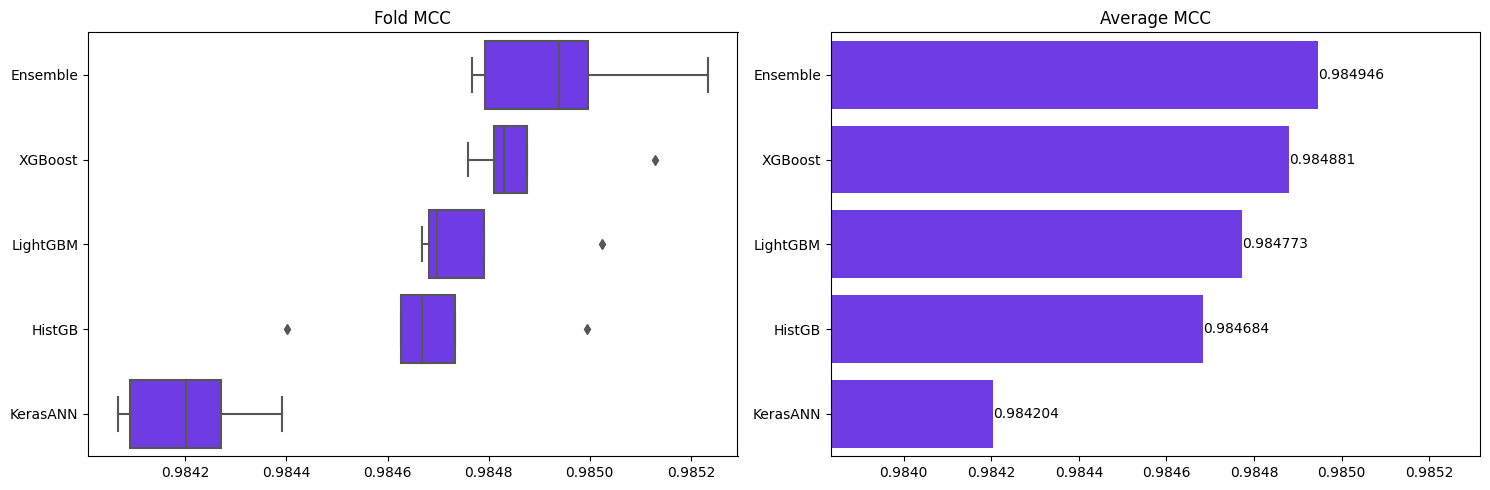

In [13]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold MCC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average MCC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()